In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math as m
import os
import datetime
import pandas as pd

In [2]:
'''Micol'''
path_raw = '/Users/micol/Documents/Imperial/Year4/Master_Project/raw_spectra' #path with raw spectra files
path_logs = '/Users/micol/Documents/Imperial/Year4/Master_Project/bruker_logs' #path with eventlog and temperatures

'''Rachel'''
#path_raw = '//icnas4.cc.ic.ac.uk/rs5115/MSci Project/raw_spectra'
#path_logs = '//icnas4.cc.ic.ac.uk/rs5115/MSci Project/bruker_logs'

temperature_log = 'thursday2-20180927113645.log' #log of temperatures
event_log = 'EventLog_20180927112225.log' #event log

In [3]:
file_array = []     #empty array to append filenames in original order (wrong order)
all_the_files = np.array([i for i in os.listdir(path_raw) if os.path.isfile(os.path.join(path_raw,i)) and i.startswith('IC_raw_spectra_')]) #all files in directory starting with 'IC_raw_spectra'

for f in all_the_files:
    file_array.append(f.strip('IC_raw_spectra.tx'))      #stripping file names to get the number at the end

file_integers = sorted([int(i) for i in file_array])     #number converted to sorted integers (not naturally done)

all_files_list = []    #file list, in order

for num in file_integers: #add integer to string to make files_list
    all_files_list.append('IC_raw_spectra_'+str(num)+'.txt')

In [4]:
"""removing files without associated temperature measurement"""

def read_temperatures_check(directory, filename):
    lines = open(os.path.join(directory, filename)).readlines() #finds all lines in file as string elements in "lines" list
    temp1 = [float(b) for b in (lines[1].split())[6:]]
    tempHBB1 = temp1[0]

    return tempHBB1

In [5]:
delete_files = [] #files where there is no temperature measurement

for f in all_files_list:
    if read_temperatures_check(path_raw, f) == 0.0:
        delete_files.append(f)

files_list = [x for x in all_files_list if x not in delete_files]

In [6]:
"""retrieving times from files"""

def read_times(directory, filename):
    lines = open(os.path.join(directory, filename)).readlines() #finds all lines in file as string elements in "lines" list
    
    times = lines[0].split() #retrieve times of beginning of all spectra in a file
    return times

In [7]:
all_times_list = [] #final time list [374x4] (in HH:MM:SS.microsec format)

for f in range(len(files_list)): #go through files_list and extract times
    all_times_list.append(read_times(path_raw, files_list[f]))

flat_list = [item for sublist in all_times_list for item in sublist] #1D list of all times (in HH:MM:SS.microsec format)

spectrum_times = [] #final time list [(374*4)x1] in seconds from midnight format
real_spectrum_times = []

for i in flat_list: #convert times to seconds format
    time = datetime.datetime.strptime(i, '%H:%M:%S.%f')
    real_spectrum_times.append(time)
    spectrum_times.append((time.microsecond)/1000000 +time.second+time.minute*60+time.hour*3600)

Code up to this point returns:

$\textbf{spectrum_times}$: a list of times of all spectra for which the temperature is not zero

$\textbf{files_list}$: a list of all raw files for which temperature is not zero

In [8]:
time_col_name = 'Time' # name the time column in all subsequent dataframes

In [9]:
# Read the log file - extract log_times and log_h_or_c
log_file = open(os.path.join(path_logs, event_log)).readlines()

log_file_list = []
for i in log_file[9:-3]: # leave out 'title' and 'footnotes' of the log file
    log_file_list.append(i.split(' '))
for i in log_file_list:
    i.pop(5)
    i.pop(4)
    i.pop(3)
    i.pop(0)
# each item has length either 3 or 4. Length 4 is at start of h/c BB measurement

In [15]:
'''create log_h_c which identifies whether spectrometer is looking at hot or cold blackbody for each associated log_times entry from the EventLog (50 hot and 50 cold)'''

log_times = [] # all times in seconds since midnight
log_times_real = []
log_h_c = []

for i in log_file_list:
    log_times_real.append(i[0])
    time = datetime.datetime.strptime(i[0]+i[1], '%I:%M:%S%p')
    log_times.append(time.second+time.minute*60+time.hour*3600)
    if len(i) == 4:
        log_h_c.append(i[-1][0])
    elif len(i) == 3:
        log_h_c.append(log_h_c[-1])
    else:
        raise Exception('Error')

In [17]:
hc_log = pd.DataFrame(
    {'Real Time': log_times_real,
    time_col_name: log_times,
     'h/c': log_h_c,
    })
hc_log.head()

,Real Time,Time,h/c
0,12:23:01,44581,h
1,12:23:03,44583,h
2,12:23:05,44585,h
3,12:23:08,44588,h
4,12:23:10,44590,h


In [18]:
'''insert_row inserts a row into a dataframe after a given index and then reindex all rows in ascending order'''

def insert_row(i, df, line):
    dfA = df.iloc[:i, ]
    dfB = df.iloc[i:, ]
    df = dfA.append(line).append(dfB).reset_index(drop = True)
    return df

In [19]:
times = spectrum_times
times.sort(reverse = True) #need to insert rows into dataframe in reverse order in order not to get messed up with indeces

#scan log_times, and insert spectra at corresponding times, with 'Nan' in the h_c column (by default)
for t in times:
    i=0
    if t > log_times[0]:
        while hc_log.at[i, time_col_name] <= t:
            i += 1   
        line = pd.DataFrame([t], columns = [time_col_name])
        hc_log = insert_row(i, hc_log, line)
    else:
        line = pd.DataFrame([t], columns = [time_col_name])
        hc_log = insert_row(i, hc_log, line)

In [20]:
hc_list = []

for i in range(hc_log.shape[0]-1):
    value = hc_log.at[i, 'h/c']
    if value != 'c' and value != 'h':
        hc_list.append(hc_log.iloc[i+1]['h/c']) # the spectra are assigned the h_c value of the following time

In [48]:
times.sort() # now they are back in ascending order

hc_and_times = pd.DataFrame(
    {'Real Time': flat_list,
    'Spectrum': times,
     'hc': hc_list
    })

hc_and_times[-10:]

,Real Time,Spectrum,hc
1406,18:25:24.836,66324.836,h
1407,18:25:38.281,66338.281,h
1408,18:29:53.151,66593.151,NaN
1409,18:30:06.646,66606.646,NaN
1410,18:30:20.096,66620.096,NaN
1411,18:30:33.542,66633.542,NaN
1412,18:31:02.119,66662.119,NaN
1413,18:31:15.613,66675.613,NaN
1414,18:31:29.053,66689.053,NaN
1415,18:31:42.492,66702.492,c


the Nans at the end are because the EventLog is no longer logging h or c while spectra are still being taken

In [24]:
# Read log temperature file
def read_log_file_temperature(directory, filename):
    lines = open(os.path.join(directory, filename)).readlines()
    hour_times = []
    for line in lines:
        hour_times.append(line[9:17])
    time = [(datetime.datetime.strptime(i[0:17], '%Y%m%d,%H:%M:%S')) for i in lines]
    time_sec = [time[i].second+time[i].minute*60+time[i].hour*3600 for i in range(len(time))]    
    temp_cold = [float((i[-6:-1])) for i in lines] # temperature of external black body
    temp_hot = [float((i[-12:-7])) for i in lines] # temperature of external black body
    return temp_hot, temp_cold, time, time_sec, hour_times

In [25]:
temp_hot, temp_cold, time, temp_time, hour_times = read_log_file_temperature(path_logs, temperature_log)

In [31]:
temp_log = pd.DataFrame(
    {'Real_Time': hour_times,
    time_col_name: temp_time,
     'hot': temp_hot,
     'cold': temp_cold
    })
temp_log[-5:]

,Real_Time,Time,cold,hot
10133,18:32:05,66725,29.23,69.88
10134,18:32:07,66727,29.22,69.88
10135,18:32:09,66729,29.23,69.88
10136,18:32:11,66731,29.23,69.88
10137,18:32:13,66733,29.23,69.88


In [27]:
temps_avg = []
temps_std = []

i=0
for spectrum in times[:-1]:
    times_list = list(filter(lambda t: (t>spectrum and t<times[i+1]) , temp_time))
    index_list = [temp_time.index(item) for item in times_list]
    if hc_list[i] == 'h':
        temps_list = [temp_hot[a] for a in index_list]
    elif hc_list[i] == 'c':
        temps_list = [temp_cold[a] for a in index_list]
    temps_avg.append(np.average(temps_list))
    temps_std.append(np.std(temps_list))
    i+=1

In [34]:
final_frame = pd.DataFrame(
    {'Real Time': flat_list[:-1], #get rid of last value because the hc_log loops around and puts a fake 'c' value for last row
    time_col_name: times[:-1],
     'h_or_c': hc_list[:-1],
     'temp_avg': temps_avg,
     'temp_std': temps_std,
    })
final_frame[0:16] #still includes Nan values at the end

,Real Time,Time,h_or_c,temp_avg,temp_std
0,12:36:59.910,45419.910,c,22.426667,0.011055
1,12:37:13.383,45433.383,c,22.448333,0.006872
2,12:37:26.855,45446.855,c,22.468571,0.008330
3,12:37:40.268,45460.268,c,22.505556,0.010657
4,12:37:58.496,45478.496,c,22.538333,0.012134
5,12:38:11.910,45491.910,c,22.565714,0.010498
6,12:38:25.383,45505.383,c,22.586667,0.004714
7,12:38:38.795,45518.795,c,22.613333,0.009428
8,12:38:58.796,45538.796,h,66.315714,0.070276
9,12:39:12.269,45552.269,h,66.380000,0.031091


In [49]:
temps_avg_4 = []
temps_std_4 = []

while len(times)%4 != 0: #because we want to group them into groups of 4 spectra
    del times[-1]

times_4 = np.reshape(np.array(times), (int(np.floor(len(times)/4)),4)) #time of the first of the four spectra

i=0
for spectra in times_4[:-1]: #get rid of remaining Nans at the bottom
    times_list = list(filter(lambda t: (t>spectra[0] and t<times_4[i+1][0]) , temp_time)) # only keep the temps between the beginning of the spectrum and the beginning of the next one  
    #times_list are all times in the temperature log associated with a value in times_4
    index_list = [temp_time.index(item) for item in times_list] # indeces associated to the above times   
    if hc_list[i*4-1] == 'h' and i != 0:
        temps_list = [temp_hot[a] for a in index_list]
    elif hc_list[i*4-1] == 'c' and i != 0:
        temps_list = [temp_cold[a] for a in index_list]
    elif i == 0:
        if hc_list[i] == 'h':
            temps_list = [temp_hot[a] for a in index_list]
        elif hc_list[i] == 'c':
            temps_list = [temp_cold[a] for a in index_list]
            
    temps_avg_4.append(np.average(temps_list))
    temps_std_4.append(np.std(temps_list)) 
    i+=1

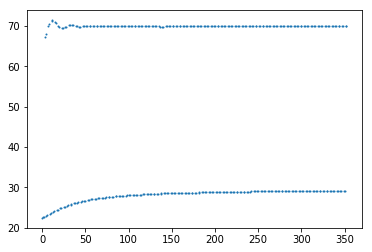

In [50]:
# check that there are no outliers
plt.scatter(np.arange(len(temps_avg_4)), temps_avg_4, s=1)
plt.show()

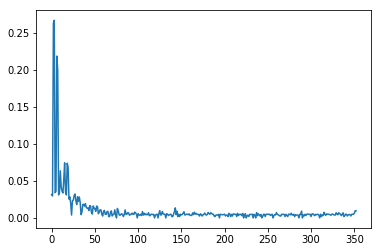

In [37]:
plt.plot(np.arange(len(temps_std_4)), temps_std_4)
plt.show()

In [38]:
hc_list_4 = hc_list[3::4]
spectra_times = [time[0] for time in times_4][:-1]

for a in hc_list_4[:-1]:
    if a != 'h' and a != 'c':
        b = hc_list_4[:-1].index(a)

final_frame_4 = pd.DataFrame(
    {'Spectrum_(time_from_midnight)': spectra_times,
     'temp_std': temps_std_4,
     'h_or_c': hc_list_4[:-1],
     'temp_avg': temps_avg_4
    })

final_frame_4 = final_frame_4.iloc[:b] #delete row with NaN in it

final_frame_4

,Spectrum_(time_from_midnight),h_or_c,temp_avg,temp_std
0,45419.910,c,22.467143,0.031493
1,45478.496,c,22.579643,0.029699
2,45538.796,h,66.579643,0.262712
3,45597.323,h,67.300000,0.266833
4,45656.645,c,22.918519,0.034070
5,45715.991,c,23.041071,0.035990
6,45774.887,h,69.211071,0.218523
7,45834.205,h,69.823929,0.199075
8,45894.485,c,23.394074,0.031063
9,45953.806,c,23.501000,0.033995


In [39]:
h = 6.626e-34
c = 3.0e+8
k = 1.381e-23

a = 2*h*(c**2)
e = h*c/k

def planck(wavenumber, T): # T in Celsius
    return 100*a*((wavenumber*100)**3)/(np.exp(e*(wavenumber*100)/T)-1)

In [40]:
def read_wavenumbers(directory, filename):
    lines = open(os.path.join(directory, filename)).readlines() #finds all lines in file as string elements in "lines" list

    wns = []
    for i in lines[5:]:
        line = i.split()
        split_lines = [float(a) for a in line]
        wns.append(split_lines[0])

    return wns

raw_wavenumbers = read_wavenumbers(path_raw, files_list[0]) #all wavenumbers are the same in all files so just need to read from the first file

22.5796428571
0.0296987425007


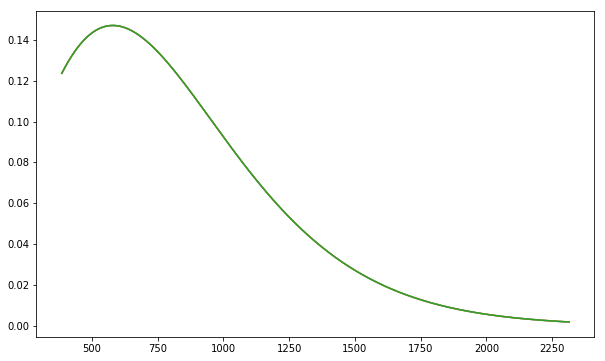

66.5796428571
0.262712256265


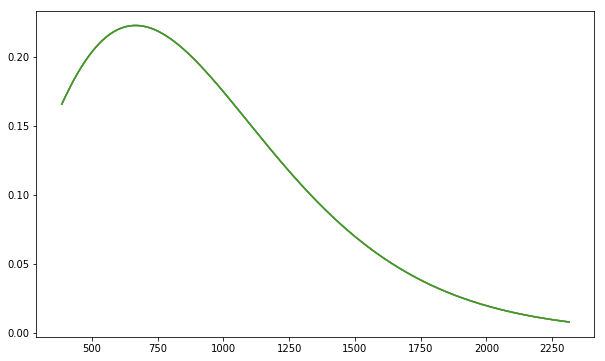

69.9327586207
0.00446947634373


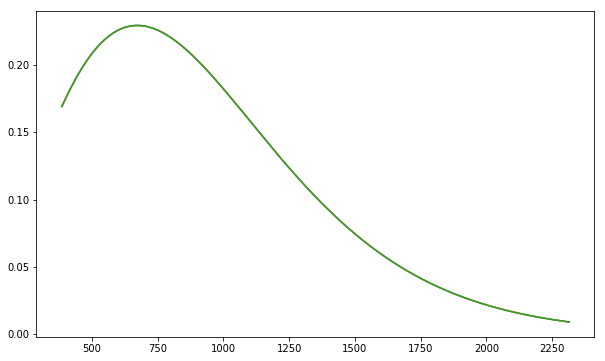

27.4839285714
0.00488385511828


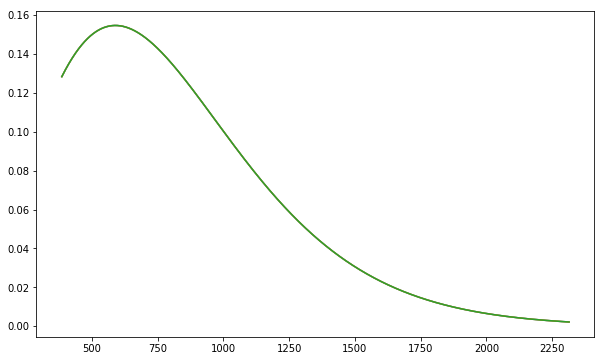

28.5393103448
0.00520678236915


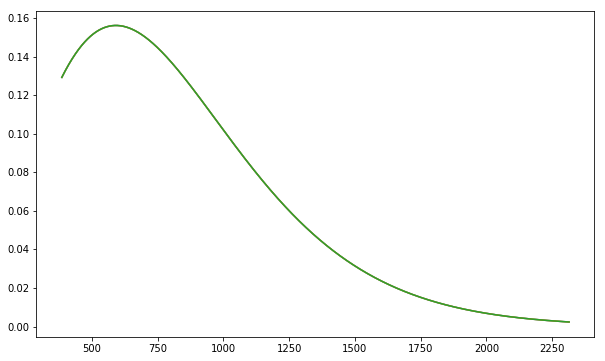

69.8418518519
0.00862255313098


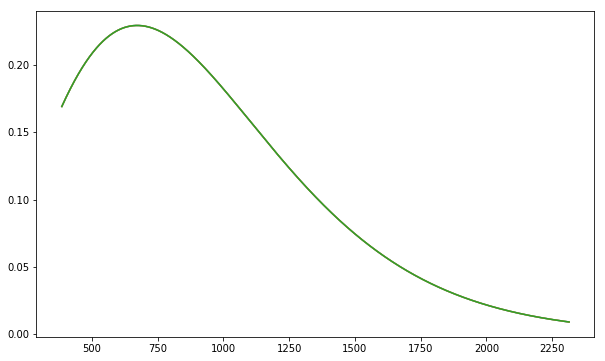

69.905862069
0.00492512305416


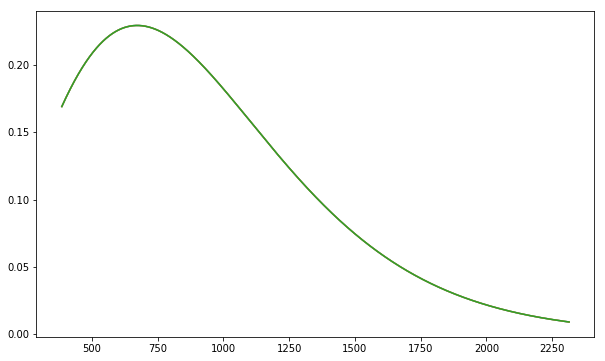

28.8842857143
0.00494871659305


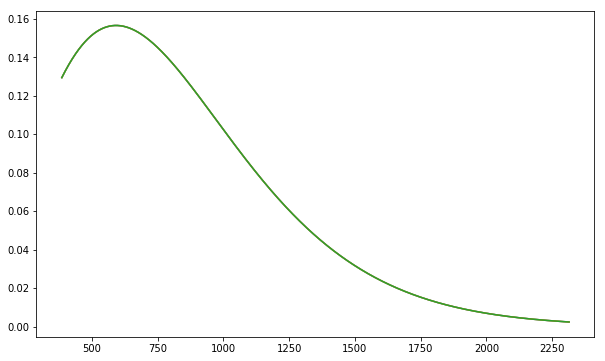

29.0903448276
0.0018246560766


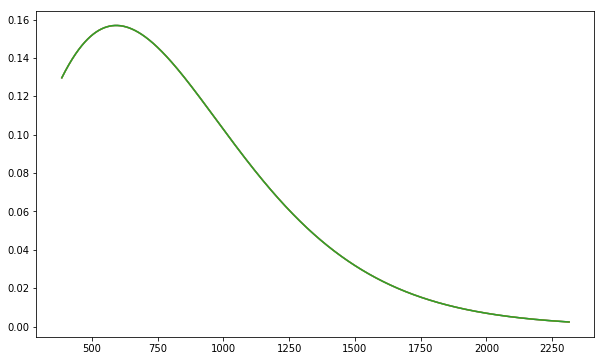

69.8907142857
0.00371153744479


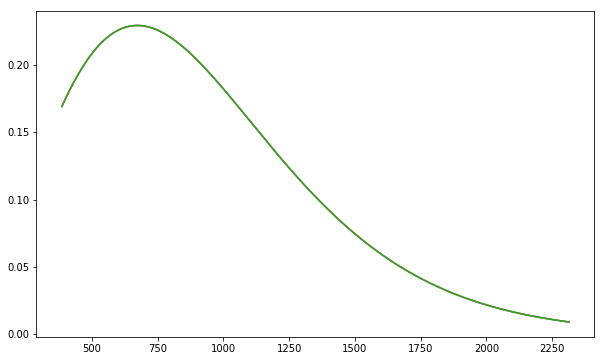

69.9162068966
0.0048521542343


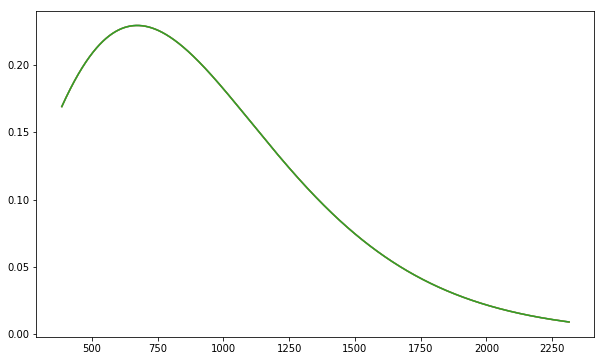

29.225
0.005


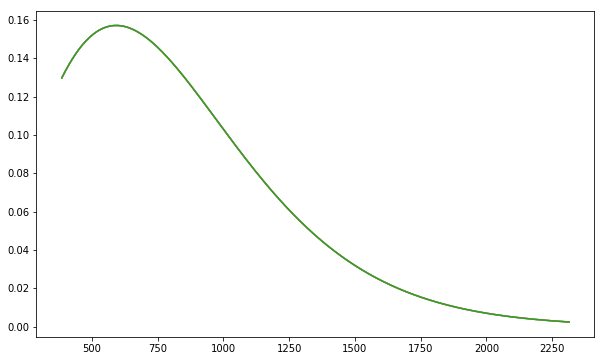

In [41]:
spectra_indeces = [1,2,71,72,141,142,211,212,281,283,347,348]
wavenums = raw_wavenumbers

for spectrum in spectra_indeces:
    temp_avg = final_frame_4.at[spectrum,'temp_avg'] #get it from the dataframe
    std = final_frame_4.at[spectrum,'temp_std']
    print(temp_avg)
    print(std)
    radiances_avg = []
    rad_minus = []
    rad_plus = []
    for wn in wavenums:
        radiances_avg.append(planck(wn, temp_avg+273.15))
        rad_minus.append(planck(wn, temp_avg+273.15-std))
        rad_plus.append(planck(wn, temp_avg+273.15+std))
    fig = plt.figure(figsize=(10,6)) 
    plt.plot(wavenums, radiances_avg)
    plt.plot(wavenums, radiances_avg)
    plt.plot(wavenums, radiances_avg)
    plt.show()

In [42]:
def read_all_raw_spectra(directory, filename):
    lines = open(os.path.join(directory, filename)).readlines() #finds all lines in file as string elements in "lines" list

    sp1 = []
    sp2 = []
    sp3 = []
    sp4 = []
    
    for i in lines[5:]:
        line = i.split()
        split_lines = [float(a) for a in line]
        sp1.append(split_lines[1])
        sp2.append(split_lines[2])
        sp3.append(split_lines[3])
        sp4.append(split_lines[4])
    
    avg_4_spec = 0.25*(np.array(sp1) + np.array(sp2) + np.array(sp3) + np.array(sp4))
    
    return avg_4_spec #list of raw value as function of wavenumber averaged over the 4 spectra

range(0, 352)


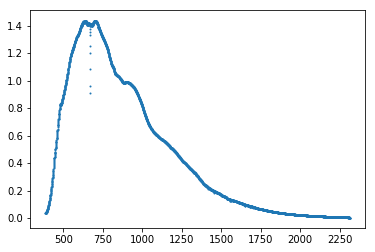

In [43]:
average_4_spectra = [] #a list with 352 elements, which is a list of 8000 points averaged over the 4 spectra

print(range(len(files_list)-2))
for f in range(len(files_list)-2):
    average_4_spectra.append(read_all_raw_spectra(path_raw, files_list[f]))
    
plt.scatter(wavenums, average_4_spectra[1], s=1)
plt.show()

22.5796428571
0.0296987425007


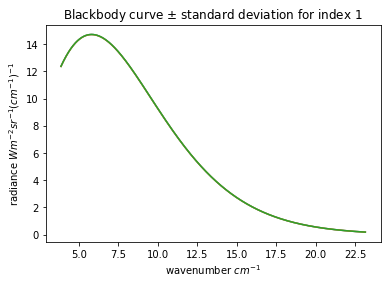

66.5796428571
0.262712256265


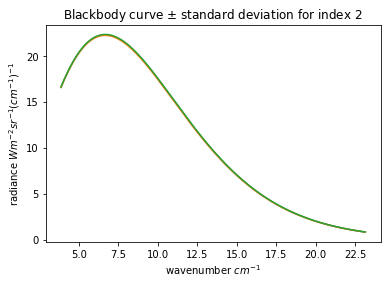

69.9327586207
0.00446947634373


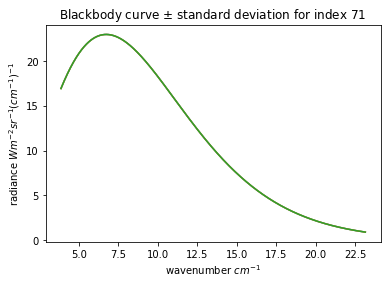

27.4839285714
0.00488385511828


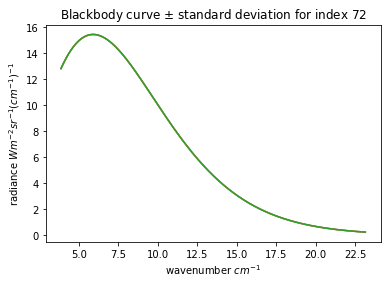

28.5393103448
0.00520678236915


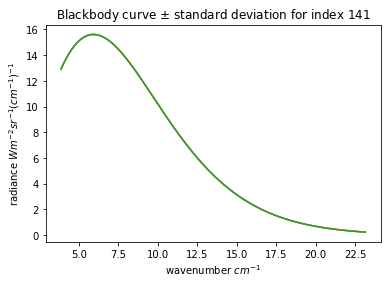

69.8418518519
0.00862255313098


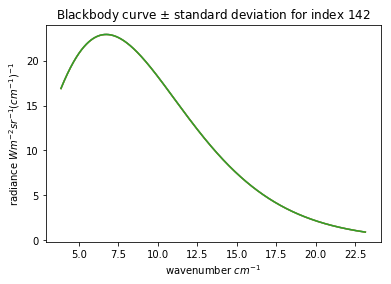

69.905862069
0.00492512305416


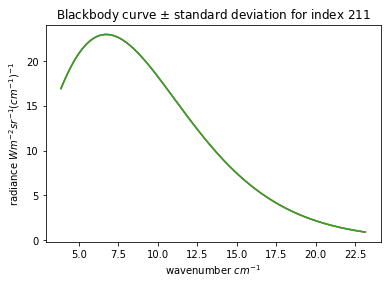

28.8842857143
0.00494871659305


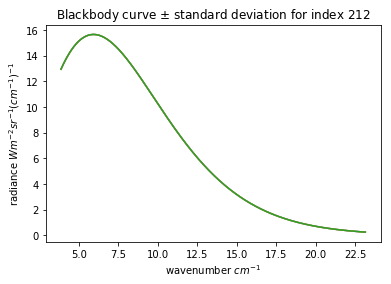

29.0903448276
0.0018246560766


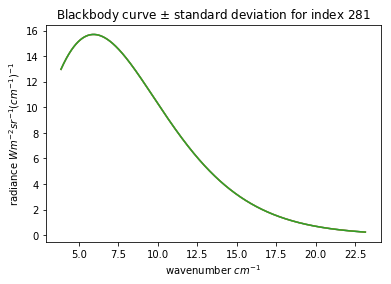

69.8907142857
0.00371153744479


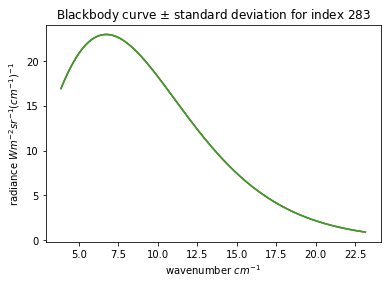

69.9162068966
0.0048521542343


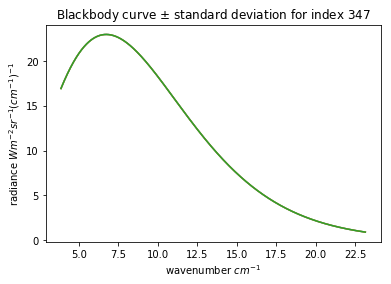

29.225
0.005


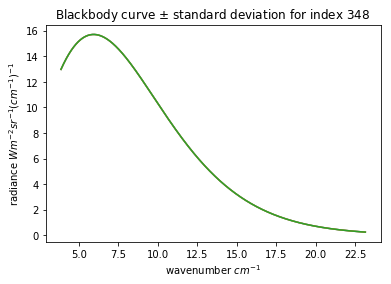

In [44]:
spectra_indices = [1,2,71,72,141,142,211,212,281,283,347,348]
wavenums = np.array(raw_wavenumbers)

for spectrum in spectra_indices:       #plot planck curve at some temperature
    temp_avg = final_frame_4.at[spectrum,'temp_avg']
    std = final_frame_4.at[spectrum, 'temp_std']
    print(temp_avg)
    print(std)
    radiances_avg = []
    rad_minus = []
    rad_plus = []
    
    for wn in wavenums:
        radiances_avg.append(planck(wn, temp_avg+273.15))
        rad_minus.append(planck(wn, temp_avg+273.15-std))
        rad_plus.append(planck(wn, temp_avg+273.15+std))

    fig = plt.figure()
    plt.plot([x/100 for x in wavenums], [r*100 for r in radiances_avg]) #might need to *100 once we have dataframe back
    plt.plot([x/100 for x in wavenums], [r*100 for r in rad_minus])
    plt.plot([x/100 for x in wavenums], [r*100 for r in rad_plus])

    plt.title('Blackbody curve $\pm$ standard deviation for index ' + str(spectrum))
    plt.xlabel('wavenumber $cm^{-1}$')
    plt.ylabel('radiance $W m^{-2} sr^{-1} (cm^{-1})^{-1}$')
    plt.show()

In [45]:
def response_fn(spectrum_number): 
    wavenums = np.array(raw_wavenumbers)
    
    (a,b) = (average_4_spectra[spectrum_number], average_4_spectra[spectrum_number + 1])
    if a[1000] < b[1000]:
        V_c = a
        V_h = b
    else:
        V_c = b
        V_h = a
    #print('V_c = {}'.format(V_c[1000]))
    #print('V_h = {}'.format(V_h[1000]))
    V_diff = np.array(V_h)-np.array(V_c)
    
    (e,f) = (final_frame_4.at[spectrum_number,'temp_avg'], final_frame_4.at[spectrum_number+1,'temp_avg'])
    if e<f:
        temp_average_c = e
        temp_average_h = f
    else:
        temp_average_c = f
        temp_average_h = e
        
    #std_dev_h = final_frame_4.at[spectrum_number, 'temp_std']
    #std_dev_c = final_frame_4.at[spectrum_number+1, 'temp_std']
    #print('temphot = {}'.format(temp_average_h))
    #print('tempcold = {}'.format(temp_average_c))
    
    radiances_avg_h = []
    radiances_avg_c = []
    #rad_minus_h = []
    #rad_plus_h = []
    
    for wn in wavenums:
        radiances_avg_h.append(planck(wn, temp_average_h+273.15))
        radiances_avg_c.append(planck(wn, temp_average_c+273.15))
        #rad_minus_h.append(planck(wn, temp_avg_h+273.15-std))
        #rad_plus_h.append(planck(wn, temp_avg_h+273.15+std))
    
    rad_diff = np.array(radiances_avg_h) - np.array(radiances_avg_c)
    
    def division(raw_val,planck_val):
        return raw_val/planck_val
    
    division_vec = np.vectorize(division)

    ratio = division_vec(V_diff, rad_diff)
    
    return(ratio)
'''    
    fig = plt.figure()
    plt.plot(wavenums, ratio)
    plt.xlabel('wavenumber $cm^{-1}$')
    plt.ylabel('response $(W m^{-2} sr^{-1} (cm^{-1})^{-1})^{-1}$ -- fix these units')
    plt.show()
'''

"    \n    fig = plt.figure()\n    plt.plot(wavenums, ratio)\n    plt.xlabel('wavenumber $cm^{-1}$')\n    plt.ylabel('response $(W m^{-2} sr^{-1} (cm^{-1})^{-1})^{-1}$ -- fix these units')\n    plt.show()\n"

In [46]:
all_resp_functions = []
indeces = np.arange(1, len(spectra_times)-2, 2)

for i in indeces:
    all_resp_functions.append(response_fn(i))

print(all_resp_functions)

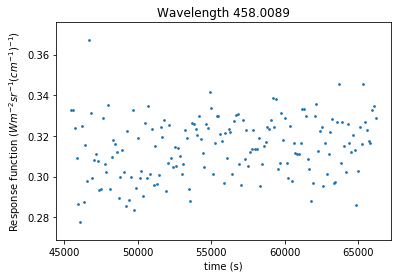

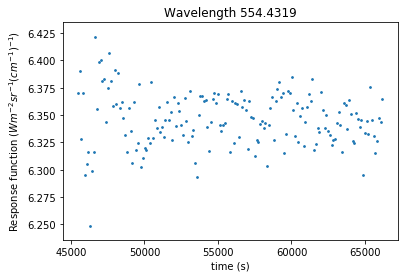

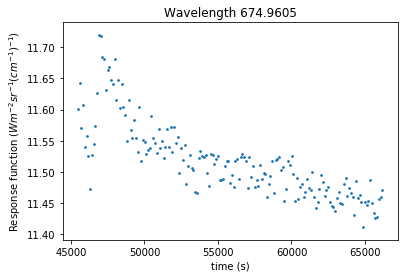

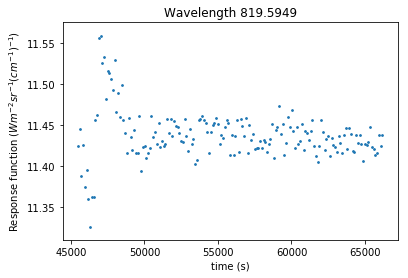

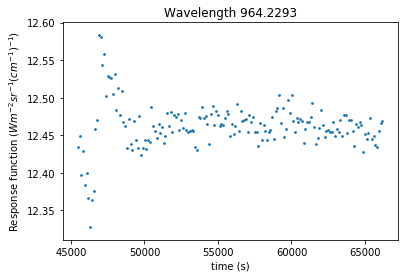

In [47]:
def plot_resp(n):
    plt.scatter(spectra_times[1:-2:2], [x[n] for x in all_resp_functions], s=3)
    plt.title('Wavelength {}'.format(raw_wavenumbers[n]))
    plt.xlabel('time (s)')
    plt.ylabel('Response function ($W m^{-2} sr^{-1} (cm^{-1})^{-1}$)')
    plt.show()
plot_resp(150)
plot_resp(350) 
plot_resp(600)
plot_resp(900) 
plot_resp(1200)

resp_std = []

for t in range(len(spectra_times[1:-2:2])-1):
    responses= []
    for i in all_resp_functions:
        responses.append(i[t])
        resp_std.append(np.std(responses))

plt.scatter(spectra_times[1:-2:2], responses, s=3)
plt.ylabel('Standard deviation')
plt.xlabel('Time')
plt.show()

In [ ]:
#need to fix units on response function
# plot std of resp function as function of wavenumber

contour plot frequency (wn) vs time, std in color
fractional change in response function
std/response
response funcgion every 2 minutes
fractional change in 2 minutes over average of whole lot
standard deviation over 10 minute cycle for example
contour plot is std of response function over 20 minute period
normalise to avg resp function if need to increase dyanmic range of color scheme